In [1]:
%matplotlib inline

import numpy as np
import scipy
import scipy.signal
from scipy.io import wavfile
import matplotlib.pyplot as plt
from navtex import ALPHABET_FIGS, ALPHABET_LTRS # See https://arachnoid.com/JNX/

In [2]:
# Load audio files
# FILENAME = 'audio/navtex_example.wav' # Downloaded from https://arachnoid.com/JNX/ 
FILENAME = 'audio/navtex_wiki.wav'  # Downloaded from https://en.wikipedia.org/wiki/Navtex
FILENAME = 'audio/websdr_recording_start_2018-05-31T10_30_24Z_518.0kHz.wav'
sample_rate, data = wavfile.read(FILENAME)
data = 1. * np.array(data) # Convert to floats

# If stero take left channel
if len(data.shape) > 1 and data.shape[1] == 2:
    data = data[:, 1]

# Filter DC
data -= np.average(data)
print sample_rate, data.shape

7119 (3666432,)


center frequency 1086.160333806818


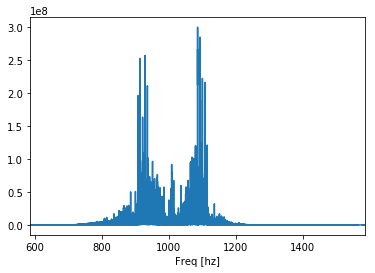

In [3]:
# Approximate center frequency by taking strongest frequency
f = np.abs(np.fft.fft(data))
fs = np.fft.fftfreq(data.size, d=1.0/sample_rate)

# Take positive frequencies
f = f[:f.size/2]
fs = fs[:fs.size/2]

center_freq = fs[np.argmax(f)]
plt.plot(fs, f)
plt.xlim([center_freq-500, center_freq+500])
plt.xlabel('Freq [hz]')
print "center frequency", center_freq

In [8]:
# NAVTEX is modulated using FSK (frequency shift keying) which we have to demodulate first

# Find acceptable frequency range
f = center_freq
f_min = (f-500.) / sample_rate
f_max = (f+500.) / sample_rate
f = f / sample_rate


# Simple PLL to recover frequency without using slow FFTs
prev_start_t = 0
fs = []
for t in range(1, len(data)):
    x = np.sin((t - prev_start_t) * 2 * np.pi * f) 
    
    # On zero crossing of received signal check phase of internal oscillator
    if data[t] > 0 and data[t-1] < 0:
        prev_start_t = t
        
        # Adjust frequency proportional to phase offset
        f -= (100.0 / sample_rate) * x
        
        # Clip to acceptable frequency range
        f = min(f, f_max)
        f = max(f, f_min)
        
    fs.append(f)
    
fs = np.array(fs)

(0, 2847)

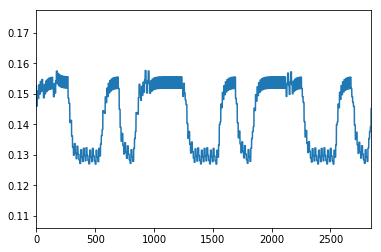

In [5]:
N = int(40 * (1./100) * sample_rate)
plt.plot(fs)
plt.xlim([0, N])

In [9]:
# Extract bits from demodulated frequency. NAVTEX is transmitted at 100 bits/sec

avg = np.average(fs) # Center frequency
expected_len = sample_rate / 100.  # 100 Baud

prev_change = 0
bits = []

for i in range(1, len(fs)):
    di = i - prev_change
    num_bits = int(round(di / expected_len))
    
    if fs[i] > avg and fs[i-1] < avg: # Rising, previous was 0
        bits += num_bits * [0]
        prev_change = i
    if fs[i] < avg and fs[i-1] > avg: # Falling, previous was 1
        bits += num_bits * [1]
        prev_change = i
        
bits = np.array(bits)

[1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1
 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 1 1
 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1]


In [22]:
# More information about the decoding process can be found here: https://arachnoid.com/JNX/
# Summarized:
# 1) Symbols are 7 bit, always 4 ones, 3 zeroes
# 2) Shift through data until symbols have 4 ones, 3 zeroes
# 3) Seperate two datastreams, indicated by [alpha] and [rep]
# 4) There are two alphabets, one for letters one for symbols. Switch on [ltrs] & [figs]
# 5) Accept characters if they are equal in both streams
# TODO: Error correction

N = 7
shift = 0

cur_alphabet_A = ALPHABET_LTRS
cur_alphabet_B = ALPHABET_LTRS

msg_a = ""
msg_b = ""
msgs_a = []
msgs_b = []

alpha_shift = 0
phased = False
phased_count = 0
for i in range(len(bits) / N):
    b = bits[i*N + shift:(i+1)*N + shift]
    s = "".join(map(str, b))
    s = s[::-1]
    if s.count('1') != 4:
        phased_count -= 1
        
        if phased_count < 5:
            shift += 1
            shift %= N
    else:
        phased_count += 1
        phased_count = min(10, phased_count)
            
        h = int(s, 2)
        if h == 0xf: # [alpha]
            phased_count = 0
            alpha_shift = i % 2
            cur_alphabet_A = ALPHABET_LTRS
            if len(msg_a) > 10:
                msgs_a.append(msg_a)
                msg_a = ""
                msgs_b.append(msg_b)
                msg_b = ""
        elif h == 0x66: # [rep]
            phased_count = 0
            alpha_shift = (i+1) % 2
            cur_alphabet_B = ALPHABET_LTRS
            
        if i % 2 == alpha_shift:
            dec = cur_alphabet_A[h]
            if dec == '[ltrs]':
                cur_alphabet_A = ALPHABET_LTRS
            elif dec == '[figs]':
                cur_alphabet_A = ALPHABET_FIGS
            elif not dec.startswith('['):
                msg_a += dec
        else:
            dec = cur_alphabet_B[h]
            if dec == '[ltrs]':
                cur_alphabet_B = ALPHABET_LTRS
            elif dec == '[figs]':
                cur_alphabet_B = ALPHABET_FIGS
            elif not dec.startswith('['):
                msg_b += dec
                
i = 0
for msg_a, msg_b in zip(msgs_a, msgs_b):
    print i
    i += 1
    msg = ""
    for a, b in zip(msg_a, msg_b):
        if a == b:
            msg += a
        else:
            msg += "?"
    print "A: ", msg_a
    print "B: ", msg_b
    print "final: ", msg
    print "-" * 20

0
A:  J
ZCZC PA19
NETHERLANDS COASTGUARD
NAVIGATIONAL WARNING NR. 19 212040 UTC MAY
WINDFARM BORSSELE
GEOPHYSICAL SURVEY BY BIBBY TETHRA 2EGF8
A. #6&003-08E
B. 51-41N 002-58E
C. 51-49N 003-08E
D. 51-49N 002-58E
WIDE BERTH REQUESTEH

ZOC
B:  
ZCZC PA19
NETHERLANDS COASTGUARD
NAVIGATIONAL WARNING NR. 19 212040 UTC MAY
WINDFARM BORSSELE
GEOPHYSICAL SURVEY BY BIBBY TETHRA 2EGF8
A. 516 &3-08E
B. 51-41N 002-58E
C. 51-49N 003-08E
D. 51-49 002-58E
WIDE BERTH REQUESTED


I
final:  ??????????????????????????????????????????????????????????????????????????????????????????S?????????????????????????????B????????????????????6???????????????????0?????????????????0?????????????????????????????????????????????
?
--------------------
1
A:  
C PA40
NETHERLANDS COASTGUARD
NAVIGATIONAL WARNING NR. 40 230327 UTC MAY
GEOTECHNICAL DRILLING OPERATIONS 
BY MV FUGRO SYNERGY / C6XR3 IN AN AREA
BOUNDED BY:
A: 52-50N 004-14E
B: 52-500
33
:: 52-36N 004-22E
D: 52-36N 004-08E
WIDE BERTH REQUESTED.
KKKKKKKKKKKKKQ
B:  
